# Strings, Regular Expressions, and Text Data Analysis

Article: 
**Andrei Lapets, Strings, Regular Expressions, and Text Data Analysis**
https://medium.com/python-supply/strings-regular-expressions-and-text-data-analysis-718df0886ef1

Jupyter notebook on Github:
https://github.com/python-supply/strings-regular-expressions-and-text-data-analysis/blob/master/strings-regular-expressions-and-text-data-analysis.ipynb

Suppose you would like to construct a data set of short definitions and facts drawn from a large text corpus such as the set of all article abstracts found in the English-language edition of Wikipedia. You would also like the workflow you assemble to be reusable and flexible, allowing you to update the data set and/or enhance its capabilities quickly. What Python features and libraries, both built-in and from the broader community, can you use to accomplish this?

While built-in string methods have limited flexibility and regular expressions have limited expressive power, both can still be leveraged in creative ways to implement scalable workflows that process and analyze text data. This article explores these tools and introduces a few useful peripheral packages and techniques within the context of the use case described above.

## Retrieving and Reading the Raw Data

Archives containing all abstracts found in the English-language edition of Wikipedia are regularly updated and available at [https://dumps.wikimedia.org/enwiki/latest/](https://dumps.wikimedia.org/enwiki/latest/) (a link you can find via [this landing page](https://en.wikipedia.org/wiki/Wikipedia:Database_download)). You decide to use the consolidated abstracts archive file containing all of the abstracts. How can you retrieve it in an automated manner? One way to retrieve a large file that is available online while also getting user-friendly feedback about progress is to use the [requests](https://requests.readthedocs.io/en/master/) library together with the [tqdm](https://pypi.org/project/tqdm/) library.

The **tqdm** library makes it possible to display an animated progress bar while an instance of an [iterable](https://docs.python.org/3/glossary.html#term-iterable) data structure emits each of its elements. The example below illustrates the output. The `position` and `leave` parameters ensure that the progress bar is not interrupted by newline characters if the output is being displayed within Jupyter Notebook.

In [1]:
import tqdm
import time
for i in tqdm.tqdm(range(3), position=0, leave=True):
    time.sleep(1)

100%|████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


The [requests](https://requests.readthedocs.io/en/master/) library makes it possible to create an iterable stream of the data from a file that is located at a specified URL by setting the [`stream`](https://requests.readthedocs.io/en/master/user/advanced/#body-content-workflow) parameter to `True`. You can then retrieve the data in chunks and [write them to a file](https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files) while displaying progress to the user. In the example below, the `total` parameter supplied to `tqdm.tqdm` is the number of 1 MB (*i.e.*, $1024^2$ byte) chunks of data in the file; it is determined by dividing file size indicated in the HTTP [response header](https://requests.readthedocs.io/en/master/user/quickstart/#response-headers) by the chosen `chunk_size` of 1 MB.

In [1]:
import requests
from math import ceil

url = "https://python.supply/"
url += "strings-regular-expressions-and-text-data-analysis/"
url += "enwiki-20191120-abstract-sample.xml.gz"

with requests.get(url, stream=True) as response:
    file_size = int(response.headers['Content-length'])
    chunk_size = 1024*1024
    with open("abstracts.xml.gz", "wb") as file:
        chunks = response.iter_content(chunk_size=chunk_size)
        for chunk in tqdm.tqdm(
                chunks, total=ceil(file_size/chunk_size),
                position=0, leave=True
            ):
            file.write(chunk)

100%|██████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


Once you have the compressed file `abstracts.xml.gz` on your disk, you can open it and iterate over the data by uncompressing it one line at a time using the built-in [gzip](https://docs.python.org/3/library/gzip.html) library. Below, the total number of lines in the file is counted using a comprehension and the built-in [`sum`](https://docs.python.org/3/library/functions.html#sum) function.

In [1]:
import gzip
with gzip.open("abstracts.xml.gz") as file:
    print(sum(1 for line in file))

238564


## Processing Raw String Data with String Functions

Given that the data set is in XML format, the most general approach to parsing it is to use an XML parser such as [lxml](https://pypi.org/project/lxml/). However, in this case the text content in the file follows a consistent format: the text for each abstract appears on its own line in its entirety, surrounded by the two element delimiters `<abstract>` and `</abstract>`. Thus, you can iterate over every line in the file and determine whether or not you want to extract it. You divide this workflow into two steps: extracting the lines, and then extracting the abstracts themselves.

First, you decide to implement a [generator](https://docs.python.org/3/glossary.html#term-generator) that iterates over all the lines in the file and yields them one at a time. In case the text data on a particular line has an unknown encoding, the [chardet](https://pypi.org/project/chardet/) library is used to check each line. This is not likely to be an issue in this particular data set, but allowing only those lines that are valid [ASCII](https://en.wikipedia.org/wiki/ASCII) or [UTF-8](https://en.wikipedia.org/wiki/UTF-8) can help you avoid any unexpected issues later in the process. Before yielding it, you convert each line from binary data into a string using the [`decode`](https://docs.python.org/3/library/stdtypes.html#bytes.decode) method of the binary data type [`bytes`](https://docs.python.org/3/library/stdtypes.html#bytes) and then remove any whitespace at the beginning or end of the string using [`strip`](https://docs.python.org/3/library/stdtypes.html#str.strip).

In [1]:
from chardet import detect
def lines():
    with gzip.open("abstracts.xml.gz") as file:
        for line in file:
            if detect(line)["encoding"] in ['ascii', 'utf-8']:
                yield line.decode().strip()

### Extract text with `startswith` and `endswith` 

How do you extract the actual text of an abstract from each line of the form `<abstract>...</abstract>`? You can take advantage of the [`startswith`](https://docs.python.org/3/library/stdtypes.html#str.startswith) and [`endswith`](https://docs.python.org/3/library/stdtypes.html#str.endswith) built-in string methods to identify these lines, and then you can use string [slice indices](https://docs.python.org/3/tutorial/introduction.html?highlight=string%20slice#strings) to extract the raw text of each abstract. The function below defines a [generator](https://docs.python.org/3/glossary.html#term-generator) that yields every abstract that appears on any line in the compressed file.

In [1]:
def abstracts():
    for line in lines():
        if line.startswith("<abstract>") and\
           line.endswith("</abstract>"):
            line = line[len("<abstract>"):-len("</abstract>")]
            yield line

You can use the [`islice`](https://docs.python.org/3/library/itertools.html#itertools.islice) function for iterable data structure instances to iterate over only a portion of the abstracts. The line below calculates the maximum length of the first 100 abstracts.

In [1]:
from itertools import islice
max(len(a) for a in islice(abstracts(), 0, 100))

553

## Extracting Strings with a Specific Structure

[Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) are mathematical constructs that can be used to describe *sets of strings* that follow a particular pattern or format. The history and conceptual details of regular expressions are far beyond the scope of this article, but you only need to understand a few basic building blocks to begin using the built-in [re](https://docs.python.org/3/library/re.html) library to identify when a string adheres to a specific pattern.

### The `compile` and `match` methods

In Python, regular expressions are represented as strings. In the example below, the regular expression `"abc"` is satisfied only by those strings that begin with the exact sequence of characters `abc`. To check whether a string satisfies a regular expression, it is sufficient to compile the regular expression string using [`compile`](https://docs.python.org/3/library/re.html#re.compile) and then to use the [`match`](https://docs.python.org/3/library/re.html#re.match) method to perform the check.

In [1]:
import re
re.compile("abc").match("abcd")

<re.Match object; span=(0, 3), match='abc'>

To ensure that only an entire string (as opposed to only a portion of the string) can satisfy a regular expression, it is possible to add `^` to the beginning of the regular expression and `$` to the end.

In [1]:
print(re.compile("^abc$").match("abc"))
print(re.compile("^abc$").match("abcd"))

<re.Match object; span=(0, 3), match='abc'>
None


### Patterns for regular expression matching

The [syntax for regular expression strings](https://docs.python.org/3/library/re.html#regular-expression-syntax) consists of a large collection of special characters and character sequences. For the purposes of the motivating example, the below syntactic constructs are sufficient:
* `[a-z]` is satisfied by any lowercase single letter;
* `\s` is satisfied by any single whitespace character and `\.` is satisfied by a period;
* given any regular expression `r`, the set of strings that satisfy `r` also satisfy `(r)` and vice versa;
* given any regular expression `r`, the set of strings that satisfy `r*` consists of all strings that are concatenations of zero or more individual strings that each independently satisfy `r` (*e.g.*, `"abc"`, `"aaaa"`, and `""` all satisfy `[a-z]*`);
* given any two regular expressions `r` and `s`, the regular expression `r|s` is satisfied by any string that satisfies either `r`, `s`, or both;
* given any two regular expressions `r` and `s`, the regular expression `rs` is satisfied by any string consisting of a portion that satisfies `r` followed immediately by a portion that satisfies `s` (*e.g.*, `"xy"` satisfies `[a-z][a-z]`, while `"x"` and `"xyz"` do not). 

### The `join` method

To make it easier to experiment quickly with larger and more complex regular expressions while reusing common building blocks, you can define functions that take smaller expressions and build larger ones. Because regular expressions are represented using Python strings, you can use string methods such as [`join`](https://docs.python.org/3/library/stdtypes.html#str.join) to accomplish this. The functions below also use [argument unpacking syntax](https://docs.python.org/3/tutorial/controlflow.html#arbitrary-argument-lists) to make code that invokes them more concise.

In [1]:
def atom(s):
    # Wrap an expression in parenthesis.
    return "(" + s + ")"

def options(*rs):
    # Given expressions r1, r2, ..., rN, build
    # the expression (r1)|(r2)|...|(rN).
    return atom("|".join([atom(r) for r in rs]))

def adjacent(*rs):
    # Given expressions r1, r2, ..., rN, build
    # the expression (r1)(r2)...(rN).
    return atom("".join([atom(r) for r in rs]))

def spaced(*rs):
    # Given expressions r1, r2, ..., rN, build
    # the expression (r1)\s(r2)\s...\s(rN).
    return atom("\s".join([atom(r) for r in rs]))

def repeated(r):
    # Given the expression r0, build ((r0)*).
    return atom(atom(r) + "*")

def repeated_spaced(r):
    # Given the expression r0, build (((r0)(\s))*(r0)).
    return adjacent(repeated(adjacent(r, "\s")), r)

The definitions below are fairly self-explanatory and use the above functions to build more complex regular expressions. These are useful as building blocks for building a regular expression that matches a sentence of the form you are trying to identify in the data.

In [1]:
article = options("A", "a", "An", "an", "The", "the")
word = atom("[a-z]+")
verb = options("are", "is")
period = atom("\.")

The definition below is for a regular expression that is satisfied by any string that (1) begins with a definite or indefinite article, (2) has any non-zero number of words following the article, (3) has a linking verb followed by one or more additional words, and (4) ends with a period.

In [1]:
sentence = adjacent(spaced(article, word, repeated_spaced(word), verb, repeated_spaced(word)), period)

You can see the actual string that the function invocations above construct. It should be apparent that assembling (or modifying) a string such as the one below manually in its raw form is likely to be an error-prone process. Abstractions such as those above are an effective way to manage complexity in regular expressions.

In [1]:
sentence

'((((((A)|(a)|(An)|(an)|(The)|(the)))\\s(([a-z]+))\\s(((((((([a-z]+))(\\s)))*))(([a-z]+))))\\s(((are)|(is)))\\s(((((((([a-z]+))(\\s)))*))(([a-z]+))))))((\\.)))'

### The `split` method

You decide to use this regular expression to identify facts and definitions in the abstracts, storing a reusable compiled version of it in as `sentence_re` for better performance. Before you check whether an abstract matches the regular expression `sentence`, you use the string method [`split`](https://docs.python.org/3/library/stdtypes.html#str.split) to separate the string into a list of substrings (*i.e.*, those substrings that are found between the instances of the `.` character in the string). You then use list index notation to keep only the first entry. Since the `split` method does not include the character used to split the string, you need to concatenate it back onto the first substring. The example below applies this workflow to a portion of the abstracts.

In [1]:
sentence_re = re.compile("^" + sentence + "$")
for a in islice(abstracts(), 0, 400):
    a = a.split(".")[0] + '.' # Keep only first sentence.
    if sentence_re.match(a) is not None:
        print(a)

An audio file format is a file format for storing digital audio data on a computer system.
The bell curve is typical of the normal distribution.
The immune system is a host defense system comprising many biological structures and processes within an organism that protects against disease.
A monolithic kernel is an operating system architecture where the entire operating system is working in kernel space.


## Basic Analysis Example

You are interested in learning more about the particular terms or phrases being described by the first sentence of each abstract. In particular, you would like to know the distribution of the number of words before the verb. One approach is to use the [`search`](https://docs.python.org/3/library/re.html#re.search) method to find the first instance of a verb and then to inspect the contents of the [Match object](https://docs.python.org/3/library/re.html#match-objects) to determine the location of the match. Then it is possible to use the string [`count`](https://docs.python.org/3/library/stdtypes.html#str.count) method on the substring (up to and including that matched verb) to determine the number of spaces (and thus, words) before the first verb.

In [1]:
counts = []
verb_re = re.compile(verb)
for abstract in tqdm.tqdm(
        abstracts(), position=0, leave=True, total=210777
    ):
    abstract = abstract.split(".")[0] + '.'
    if sentence_re.match(abstract) is not None:
        if (m := verb_re.search(abstract)) is not None:
            counts.append(abstract[:m.end()].count(" "))

100%|█████████████████████████████████████████| 210777/210777 [06:05<00:00, 576.85it/s]


You may notice in the above example the use of an [assignment expression](https://www.python.org/dev/peps/pep-0572/) involving the `:=` operator. Scenarios such as this one play a significant role in the rationale for this new feature (introduced in Python 3.8). The alternative syntax would have required a separate line for the statement `m = verb_re.search(abstract)`.

Now that the number of words before the verb in each abstract is in the list of integers `counts`, it is straightforward to generate a histogram using [Matplotlib](https://matplotlib.org/). The results suggest that the most common case is one involving three words before the verb (which, given that the initial [definite or indefinite article](https://en.wikipedia.org/wiki/Article_(grammar)) is also being counted, suggests that most abstracts refer to a concept described by a two-word phrase).

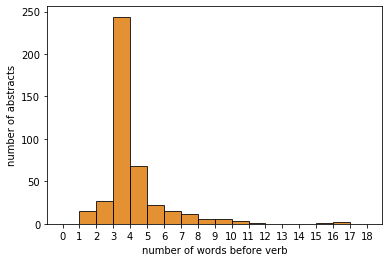

In [1]:
import matplotlib.pyplot as plt
plt.hist(
    counts,
    bins=range(max(counts)), density=False, histtype="bar",
    color="#DD7600", edgecolor="k", alpha=0.8
)
plt.ylabel("number of abstracts")
plt.xlabel("number of words before verb")
plt.xticks(range(0, max(counts)))
plt.show()

## Further Reading

This article reviews a use case while referencing or employing techniques that are drawn from a broad array of disciplines and topic areas: data science (specificially, [data cleaning](https://en.wikipedia.org/wiki/Data_cleansing)), [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load), parsing and data structure search and traversal, text data analysis and natural language processing, regular expressions and regular language grammars, web scraping, and a few others. Providing more detailed directions for exploring each of these further is beyond the scope of this article, but a few points that relate specifically to implementing such workflows in Python are worth noting.

The [regex](https://pypi.org/project/regex/) package is backwards-compatible with the built-in [re](https://docs.python.org/3/library/re.html) library but offers additional features such as fuzzy matching. The long-lived [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) library is described as a tool for parsing HTML and XML documents (typically in scenarios involving web scraping), but is actually a powerful text data processing tool in its own right. An assortment of sophisticated natural language processing tools and techniques are available in the [Natural Language Toolkit](https://www.nltk.org/), including the ability to tokenize, tag, and parse text. Finally, towards the machine learning end of the spectrum are libraries like [Gensim](https://radimrehurek.com/gensim/), which provide capabilities such as [topic modeling](https://en.wikipedia.org/wiki/Topic_model).


**Chardet** library:
https://pypi.org/project/chardet/


Create a progress bar with **tqdm** package:
https://pypi.org/project/tqdm/


**Natural Language Processing** packages:

- Textblob https://textblob.readthedocs.io/en/dev/
- NLTK https://www.nltk.org/
- Gensim https://github.com/piskvorky/gensim
- Spacy https://domino.ai/blog/natural-language-in-python-using-spacy
